In [1]:
# Load necessary packages
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.linear_model
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

# Set seed for reproducibility 
SEED = 3

In [2]:
# Load data
data = pd.read_csv("ProviderInfo.csv")

## Part I. Data Processing

a) Import the data: Only keep numeric data (pandas has tools to do this!). Drop "PHONE" and "COUNTRY_SSA" as well. Verify that your data has the following shape: (15617, 28)

In [3]:
# Get dataframe summary
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15617 entries, 0 to 15616
Data columns (total 78 columns):
PROVNUM                      15616 non-null object
PROVNAME                     15616 non-null object
ADDRESS                      15616 non-null object
CITY                         15616 non-null object
STATE                        15616 non-null object
ZIP                          15616 non-null float64
PHONE                        15616 non-null float64
COUNTY_SSA                   15616 non-null float64
COUNTY_NAME                  15616 non-null object
OWNERSHIP                    15615 non-null object
BEDCERT                      15616 non-null float64
RESTOT                       15105 non-null float64
CERTIFICATION                15616 non-null object
INHOSP                       15616 non-null object
LBN                          15616 non-null object
PARTICIPATION_DATE           15616 non-null object
CCRC_FACIL                   15616 non-null object
SFF                

In [4]:
# Select only numeric data 
df = data.select_dtypes(include=['float64'])
# Delete selected columns 
df.drop(['PHONE','COUNTY_SSA'], axis=1, inplace=True)
# Verify dimension
df.shape

(15617, 28)

b) This data is extra messy and has some NaN and NaT values, which need to be removed completely. Hint: NaT values should be replaced by "np.nan." After this step, remove any rows that have an NaN value. Verify that your dataframe was properly updated to the following shape: (14557, 28)

In [5]:
# Replace NaT values
df.replace("NaT", np.nan)
# Drop rows will null values 
df.dropna(axis = 0,inplace = True)
# Verify dimension
df.shape

(14557, 28)

c) Split into train / test set using an 80/20 split.

In [6]:
# First, create X & y objects
y = df['OVERALL_RATING']
X = df.drop(['OVERALL_RATING'], axis=1)
print(X.shape)
print(y.shape)

(14557, 27)
(14557,)


In [7]:
# Split into train and test data, randome_state = SEED for reproducibility
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state = SEED)

d) Scale X_train data properly (Do not scale the Target Variable): Recall from HW #2 the proper method of scaling.

In [8]:
# Fit standard scaler on X_train data and transform both X_train and X_test data  
stscaler = StandardScaler().fit(X_train)
X_train_scaled = stscaler.transform(X_train)
X_test_scaled = stscaler.transform(X_test)

## Part II. Model 1: Logistic Regression

a) Pick up from step d in Problem 1 (use the same data that has been scaled): Using LogisticRegression(), build a model to predict the "OVERALL_RATING". Note: The default in sklearn is "one-vs-rest" classification, where we calculate the probability of each class compared to the rest. Please use this for your homework. 

In [9]:
# Create a logistic regression instance with one-vs-reat classification
clf = LogisticRegression(random_state=SEED, multi_class='ovr')
# Fit the scaled X_train data and y_train
clf.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=3,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

b) For error evaluation, start by calculating the score (returns the mean accuracy).You can use the .score() method.

In [10]:
# Calculate test accuracy
acc1_test = clf.score(X_test_scaled, y_test) 
print("test accuracy:", acc1_test)

test accuracy: 0.7118818681318682


c) Calculate the confusion matrix and classification report for the test data (both are in sklearn.metrics).
To do this, you will need to first predict the class of each observation in the test data. 

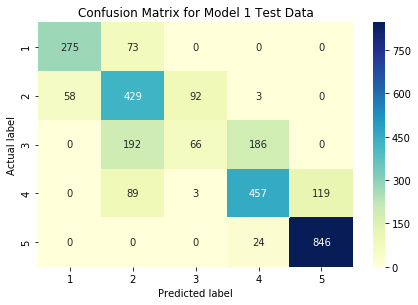

In [11]:
# Predict test data and generate confusion matrix and classification report 
y_pred = clf.predict(X_test_scaled)
cnf1_test = metrics.confusion_matrix(y_test, y_pred)
clr1_test = metrics.classification_report(y_test, y_pred)

# Put confusion matrix into a dataframe with labels for plotting 
class_names = [1,2,3,4,5]
df_cnf1_test = pd.DataFrame(cnf1_test, index=class_names, columns=class_names)

# Create Heatmap for Confusion Matrix 
sns.heatmap(df_cnf1_test, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Model 1 Test Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [12]:
# Print classification report
print(clr1_test)

              precision    recall  f1-score   support

         1.0       0.83      0.79      0.81       348
         2.0       0.55      0.74      0.63       582
         3.0       0.41      0.15      0.22       444
         4.0       0.68      0.68      0.68       668
         5.0       0.88      0.97      0.92       870

    accuracy                           0.71      2912
   macro avg       0.67      0.67      0.65      2912
weighted avg       0.69      0.71      0.69      2912



d) Based on the confusion matrix and classification report, do any of the classes get predicted exceptionally poorly?If so, comment briefly on what might be causing this to happen (Hint: Very open-ended). 

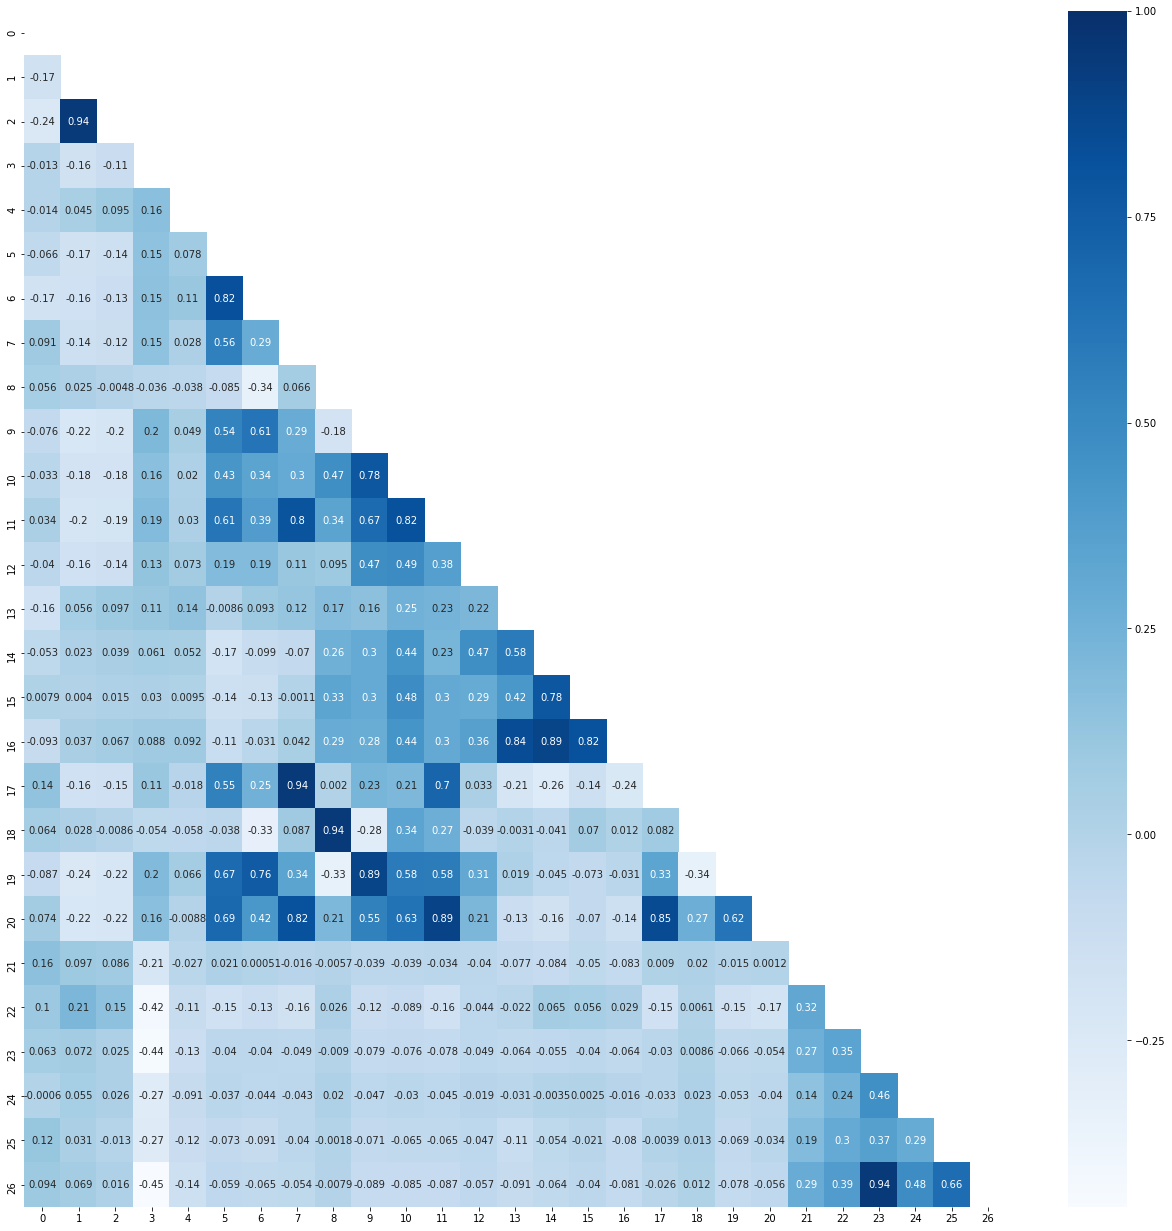

In [38]:
# Calculate correlations 
rho = pd.DataFrame(X_train_scaled).corr()

# This will help remove the redundant half of correlation heatmap 
mask = np.zeros(rho.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

# Plot correlation heatmap 
plt.figure(figsize=(22, 22))
sns.heatmap(rho, annot=True, cmap="Blues", mask = mask)

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

Class 3 was very poorly predicted, being the lowest in terms of precision, recall and f1-score among all classes. A possible reason is the presence of multicollinearity between certain predictors. The correlation heatmap above shows high correlation between features 7 and 11 (rho=0.8), features 7 and 17 (rho=0.94), features 9 and 19 (rho=0.89), etc. Since logistic regression belongs to the class of generalized linear models, it is prone to suffer from unstable estimates and inaccurate variances caused by multicollinearity, which in turn affects model parameters and confidence intervals. 

e) Calculate predictions for the training data & build the confusion matrix and classification report. Are there signs of overfitting? Why or why not?

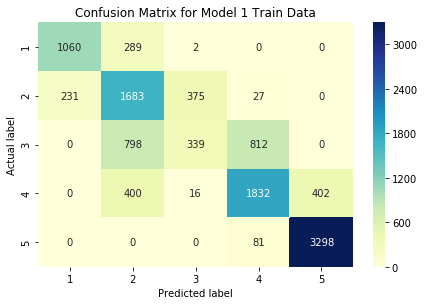

In [14]:
# Predict train data and generate confusion matrix and classification report 
y_pred_train = clf.predict(X_train_scaled)
cnf1_train = metrics.confusion_matrix(y_train, y_pred_train)
clr1_train = metrics.classification_report(y_train, y_pred_train)

# Put confusion matrix into a dataframe with labels for plotting 
class_names = [1,2,3,4,5]
df_cnf1_train = pd.DataFrame(cnf1_train, index=class_names, columns=class_names)

# Create Heatmap for Confusion Matrix 
sns.heatmap(df_cnf1_train, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Model 1 Train Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [15]:
# Print classification report for train data
print(clr1_train)

              precision    recall  f1-score   support

         1.0       0.82      0.78      0.80      1351
         2.0       0.53      0.73      0.61      2316
         3.0       0.46      0.17      0.25      1949
         4.0       0.67      0.69      0.68      2650
         5.0       0.89      0.98      0.93      3379

    accuracy                           0.71     11645
   macro avg       0.67      0.67      0.66     11645
weighted avg       0.69      0.71      0.68     11645



In [16]:
# Calculate train accuracy for train 
acc1_train = clf.score(X_train_scaled, y_train)
print("train accuracy:", acc1_train)
print("test accuracy:", acc1_test)

train accuracy: 0.7051953628166595
test accuracy: 0.7118818681318682


There's no signs of overfitting since the accuracy scores from train and test data are very similar. This suggests that the model has learned the generalized pattern from the train data and is able to achive the same level of accuracy when making predictions on the test data.

f) Print out an example of the predicted probability. There is a method called .predict_proba() which can be used for estimating these values on the test set. This will be critical to understand for future questions.

In [17]:
# See predicted probabilities of the first 5 instances 
clf.predict_proba(X_test_scaled)[0:5]

array([[4.67971519e-05, 3.33829602e-01, 2.44130319e-01, 4.16996739e-01,
        4.99654327e-03],
       [2.39717001e-05, 7.40571380e-02, 2.88934751e-01, 3.72146822e-01,
        2.64837318e-01],
       [5.20750104e-10, 2.63439542e-03, 5.76481511e-02, 2.73810412e-01,
        6.65907041e-01],
       [5.24368290e-10, 1.54248395e-03, 1.31338499e-02, 1.01652133e-01,
        8.83671532e-01],
       [1.08676039e-06, 1.77184784e-02, 1.30626578e-01, 2.40555224e-01,
        6.11098634e-01]])

## Part III. Model 2: PCA(n_components = 2) + Logistic Regression

a) Pick up from step d in Problem 1 (use the same data that has been scaled): We will now transform the X_train & X_test data using PCA with 2 components. Hint: the PCA class in sklearn can be used similarly to how we have used StandardScaler class (fit_transform on train and transform on test). 
- Transform X_train and call it X_train_pca_2
- Transform X_test and call it X_test_pca_2

In [18]:
# Create a PCA instance with 2 components and fit on the X_train_scaled data 
pca2 = PCA(n_components = 2, random_state = SEED).fit(X_train_scaled) 
# Transform both X_train_scaled and X_test_scaled data  
X_train_pca_2 = pca2.transform(X_train_scaled)
X_test_pca_2 = pca2.transform(X_test_scaled)

b) Then use the transformed data (X_train_pca_2) to fit a Logistic Regression model.

In [19]:
# Create a logistic regression instance with one-vs-reat classification
lg = LogisticRegression(random_state=SEED, multi_class='ovr')
# Fit on X_train_pca_2 and y_train
lg.fit(X_train_pca_2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=3,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

c) Calculate the confusion matrix and classification report for the test data.

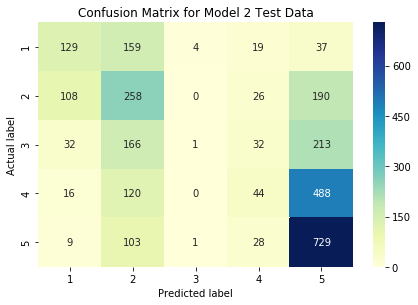

In [20]:
# Predict test data and generate confusion matrix and classification report 
y_pred_pca_2 = lg.predict(X_test_pca_2)
cnf2_test = metrics.confusion_matrix(y_test, y_pred_pca_2)
clr2_test = metrics.classification_report(y_test, y_pred_pca_2)

# Put confusion matrix into a dataframe with labels for plotting 
class_names = [1,2,3,4,5]
df_cnf2_test = pd.DataFrame(cnf2_test, index=class_names, columns=class_names)

# Create Heatmap for Confusion Matrix 
sns.heatmap(df_cnf2_test, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Model 2 Test Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [21]:
# Print classification report
print(clr2_test)

              precision    recall  f1-score   support

         1.0       0.44      0.37      0.40       348
         2.0       0.32      0.44      0.37       582
         3.0       0.17      0.00      0.00       444
         4.0       0.30      0.07      0.11       668
         5.0       0.44      0.84      0.58       870

    accuracy                           0.40      2912
   macro avg       0.33      0.34      0.29      2912
weighted avg       0.34      0.40      0.32      2912



d) Calculate predictions for the training data & build the confusion matrix and classification report. Are there signs of overfitting? Why or why not?

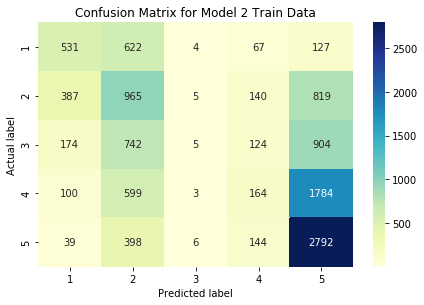

In [22]:
# Predict train data and generate confusion matrix and classification report 
y_pred_train_pca_2 = lg.predict(X_train_pca_2)
cnf2_train = metrics.confusion_matrix(y_train, y_pred_train_pca_2)
clr2_train = metrics.classification_report(y_train, y_pred_train_pca_2)

# Put confusion matrix into a dataframe with labels for plotting 
class_names = [1,2,3,4,5]
df_cnf2_train = pd.DataFrame(cnf2_train, index=class_names, columns=class_names)

# Create Heatmap for Confusion Matrix 
sns.heatmap(df_cnf2_train, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Model 2 Train Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [23]:
# Print classification report
print(clr2_train)

              precision    recall  f1-score   support

         1.0       0.43      0.39      0.41      1351
         2.0       0.29      0.42      0.34      2316
         3.0       0.22      0.00      0.01      1949
         4.0       0.26      0.06      0.10      2650
         5.0       0.43      0.83      0.57      3379

    accuracy                           0.38     11645
   macro avg       0.33      0.34      0.29     11645
weighted avg       0.33      0.38      0.30     11645



 e) How well does this model perform relative to Model #1? Explain why there is a shift in performance. 

In [24]:
# Compare train and test accuracy scores for model 2 
acc2_train = lg.score(X_train_pca_2,y_train)
acc2_test = lg.score(X_test_pca_2,y_test)
print("train accuracy:", acc2_train)
print("test accuracy:", acc2_test)

train accuracy: 0.3827393731215114
test accuracy: 0.39869505494505497


The test and train accuracy scores for model 2 are quite similar, so there's no signs of overfitting. However, compared to model 1 where train and test accuracy are at 0.71, this is a significant decrease in model performace. This is because in model 2 where PCA was applied, only 2 principal components were kept and this is not enough to explain the majority of the variance in the data. Therefore, the model has not captured most of the variability in the data and suffers from underfitting.  

## Part IV Model #3: PCA (n_components = 16) + Logistic Regression

a) Pick up from step d in Problem 1 (use the same data that has been scaled): We will now transform the X_train & X_test data using PCA with 16 components. 
- Transform X_train and call it X_train_pca_16
- Transform X_test and call it X_test_pca_16

In [25]:
# Create a PCA instance with 16 components and fit on X_train_scaled 
pca16 = PCA(n_components = 16, random_state = SEED).fit(X_train_scaled) 
# Transform both X_train_scaled and X_test_scaled
X_train_pca_16 = pca16.transform(X_train_scaled)
X_test_pca_16 = pca16.transform(X_test_scaled)

b) Then use the transformed data (X_train_pca_16) to fit a Logistic Regression model.

In [26]:
# Create a logistic regression instance with one-vs-reat classification
lr = LogisticRegression(random_state=SEED, multi_class='ovr')
# Fit on X_train_pca_16 and y_train
lr.fit(X_train_pca_16, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2', random_state=3,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

c) Calculate the confusion matrix and classification report for the test data.

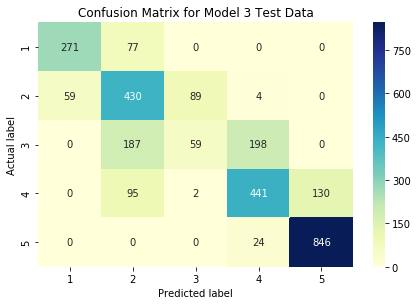

In [27]:
# Predict test data and generate confusion matrix and classification report 
y_pred_pca_16 = lr.predict(X_test_pca_16)
cnf3_test = metrics.confusion_matrix(y_test, y_pred_pca_16)
clr3_test = metrics.classification_report(y_test, y_pred_pca_16)

# Put confusion matrix into a dataframe with labels for plotting 
class_names = [1,2,3,4,5]
df_cnf3_test = pd.DataFrame(cnf3_test, index=class_names, columns=class_names)

# Create Heatmap for Confusion Matrix 
sns.heatmap(df_cnf3_test, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Model 3 Test Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [28]:
# Print classification report for test data 
print(clr3_test)

              precision    recall  f1-score   support

         1.0       0.82      0.78      0.80       348
         2.0       0.54      0.74      0.63       582
         3.0       0.39      0.13      0.20       444
         4.0       0.66      0.66      0.66       668
         5.0       0.87      0.97      0.92       870

    accuracy                           0.70      2912
   macro avg       0.66      0.66      0.64      2912
weighted avg       0.68      0.70      0.68      2912



d) Calculate predictions for the training data & build the confusion matrix and classification report. Are there signs of overfitting? Why or why not?

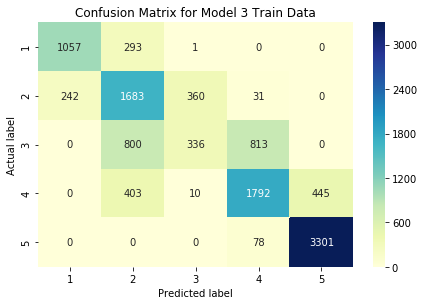

In [29]:
# Predict train data and generate confusion matrix and classification report 
y_pred_train_pca_16 = lr.predict(X_train_pca_16)
cnf3_train = metrics.confusion_matrix(y_train, y_pred_train_pca_16)
clr3_train = metrics.classification_report(y_train, y_pred_train_pca_16)

# Put confusion matrix into a dataframe with labels for plotting 
class_names = [1,2,3,4,5]
df_cnf3_train = pd.DataFrame(cnf3_train, index=class_names, columns=class_names)

# Create Heatmap for Confusion Matrix 
sns.heatmap(df_cnf3_train, annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for Model 3 Train Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

In [30]:
# Print classification report
print(clr3_train)

              precision    recall  f1-score   support

         1.0       0.81      0.78      0.80      1351
         2.0       0.53      0.73      0.61      2316
         3.0       0.48      0.17      0.25      1949
         4.0       0.66      0.68      0.67      2650
         5.0       0.88      0.98      0.93      3379

    accuracy                           0.70     11645
   macro avg       0.67      0.67      0.65     11645
weighted avg       0.69      0.70      0.68     11645



In [31]:
# Compare train and test accuracy scores for model 3 
acc3_train = lr.score(X_train_pca_16,y_train)
acc3_test = lr.score(X_test_pca_16,y_test)
print("train accuracy:", acc3_train)
print("test accuracy:", acc3_test)

train accuracy: 0.7015027908973809
test accuracy: 0.7029532967032966


Since the train and test accuracy are very close to one another, there's no sign of overfitting. Compared to model 1 where train and test accuracy are at 0.71, the performance of model 3 is very similar, which means that the PCA instance with 16 principal components applied in model 3 has explained most of the variance in the training data. This is a case of successful dimension-reduction where we've decreased the dimension from 27 to 16 without compromising variability in the data.  

## Part V. Conceptual Questions: 

a) In order to better understand what is happening in Model 2 & Model 3, rerun PCA without specifying a number of components. Plot out the cumulative explained variance ratio vs number of components for the original scaled data. Describe what the plot is showing as well as what the cumulative explained variance tells us about our data.

Text(0, 0.5, 'Cumulative Explained Variance')

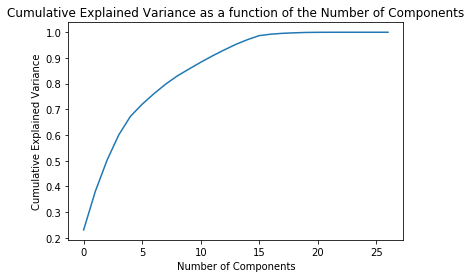

In [32]:
pca = PCA(random_state = SEED).fit(X_train_scaled)
# Plot cumulative explained variance ratio 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance as a function of the Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [33]:
print(pca2.explained_variance_ratio_.sum())
print(pca16.explained_variance_ratio_.sum())

0.3812458321646288
0.9868784480346355


PCA is a dimension-reduction algorithm that projects data onto lower dimensional space by generating principal components that account for the variance in the training set. The first principal component will account for the highest variance; the amount of explained variance decreases as the number of principal components increases. The plot shows the cumulative explained variance ratio by the number of components, and we can see the curve increasing significantly and almost reaching 1.0 at around 18 components. 

In the previous cell, we can see that with 2 principal components kept (as in Model 2), we managed to capture 38.1% of the variance in the scaled training data. With 16 principal components kept (as in Model 3), however, 98.7% of the variance in the training data was accounted for. Thus, Model 3 has been trained on much more variation in the data.

b) Between Model 2 and Model 3, which performed the best? Explain why this is.

In [34]:
print("Model 2 Classification Report on Test Data")
print(clr2_test)
print("*"*60)
print("Model 3 Classification Report on Test Data")
print(clr3_test)

Model 2 Classification Report on Test Data
              precision    recall  f1-score   support

         1.0       0.44      0.37      0.40       348
         2.0       0.32      0.44      0.37       582
         3.0       0.17      0.00      0.00       444
         4.0       0.30      0.07      0.11       668
         5.0       0.44      0.84      0.58       870

    accuracy                           0.40      2912
   macro avg       0.33      0.34      0.29      2912
weighted avg       0.34      0.40      0.32      2912

************************************************************
Model 3 Classification Report on Test Data
              precision    recall  f1-score   support

         1.0       0.82      0.78      0.80       348
         2.0       0.54      0.74      0.63       582
         3.0       0.39      0.13      0.20       444
         4.0       0.66      0.66      0.66       668
         5.0       0.87      0.97      0.92       870

    accuracy                          

As can be seen, the accuracy of model 3 (0.70) is much higher than that of model 2 (0.4). For every single class, the precision, recall and f1-score of model 3 are also higher than those of model 2. The reason for such difference in model performance is due to the number of principal components kept while training the data. As per question b), more principal components were kept while training model 3, so that model 3 has learned much more variation in the data. This helps model 3 to capture the overall pattern of tha data and have better performance in prediction. 

c) Assuming you are working with a company on a modeling project with a massive data set, what would be some of the benefits of utilizing PCA? 

On a massive dataset, PCA has the following advantages: 
- It's an unsupervised technique so it does not require the labeling of data, saving time and resources. 
- A dimension-reduction technique, PCA can reduce data size while still capturing variability in the data. This helps  reduce the demand on computational power and cost, and decrease the time spent on model training. 
- Since PCA works by finding orthogonal axes that account for variance in the dataset, it automatically resolves multicollinearity among variables as orthogonal pricipal components are linearly indepedent. 
- As PCA process works by finding the principal components that explains the most variation to the least variation, as we reduce dimension, noise captured by the less important principal components is also reduced. 

d) Now argue the opposite of question 3 - what is a negative result of utilizing this dimensionality reduction technique? 

Here are some drawbacks of PCA: 
- After applying PCA, the original features get replaced by principal components and it becomes difficult if you were to try to make sense of what features are important for modeling, thereby decreasing interpretability. 
- Although PCA tries to capture the majority of the variance in the dataset, if we don't select carefully the number of principal components to be retained, we may experience loss of information. 
- It is necessary to standardize data before applying PCA, and standardization requires numeric data types. So if we have a massive dataset with lots of categorial features, it would take a lot of effort to convert and standardize. 

e) sklearn offers a variety of methods to solve a multiclass logistic regression problem. One option is the "one-vs-the-rest" (also known as "one-vs-all" method). Explain in detail what this process does.
Hint: Run the .predict_proba() method for one of your prior models to have a better understanding of "one-vs-the-rest" output.

The one-vs-rest method is one in which a separate logistic regression model is trained for each class, predicting whether an observation is that class or not and making the prediction a binary classification. An underlying assumption is that each classification probelm (e.g. class A or not) is independent. To give a more illustrated example, assume we're using one-vs-rest logistic regression to classify a target variable into one of the 4 classes, A,B,C,D. The one-vs-rest logistic regression algorithm will build 4 classifiers: 
- classfier 1: A and not A (i.e. B,C,D)
- classfier 2: B and not B (i.e. A,C,D)
- classfier 3: C and not C (i.e. A,B,D)
- classfier 4: D and not D (i.e. A,B,C)
For each observation, the model will pick the class that has the highest probability among the 4 classifications.  

In [35]:
prob = lr.predict_proba(X_test_pca_16)[0]
total = lr.predict_proba(X_test_pca_16)[0].sum()
print("Model 3 Predicted Probability for 1st instance:", prob)
print("Sum of predicted probability for 1st instance:", total)
print("Model 3 Prediction for 1st instance:", y_pred_pca_16[0])

Model 3 Predicted Probability for 1st instance: [7.46748292e-05 3.37907457e-01 2.49717300e-01 4.07785702e-01
 4.51486544e-03]
Sum of predicted probability for 1st instance: 1.0
Model 3 Prediction for 1st instance: 4.0


In the above cell, we can see the predicted probability for each of the 5 classes on 1 observation. The sum of predicted probability of equals 1. Since the probability is highest for the 4th class (0.408), the given prediction is 4. 

f) Each of the three models utilized logistic regression. The Hands-On ML book describes the logistic function (sometimes called the sigmoid function) in detail. Using Equation 4-14, plot out the logistic function & describe why it is useful in classification problems of the nature covered in this homework assignment.

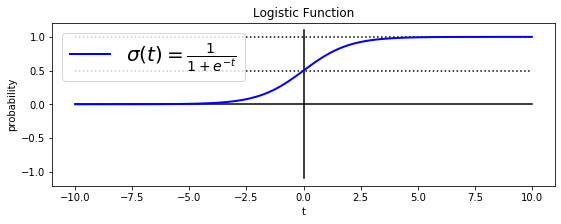

In [36]:
# Plot logistic function 
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.title("Logistic Function")
plt.xlabel("t")
plt.ylabel("probability")
plt.legend(loc="upper left", fontsize=20)
plt.show()

As can be seen, the probability (y-value) of the logistic function is bounded by 0 and 1. And the value of t (on the x-axis) in a logistic function has the range (－∞, ＋∞).

In logistic regression, after applying multiplication between n dimension of training data and the coefficient matrix, we get a number t with range of (－∞, ＋∞). t is then passed to the sigmoid function and we can get an output between 0 and 1, which will be our predicted probability. 
The process can be written with matrix operation:
t = X × w
Then pass t in the sigmoid function: 
S = 1/(1+e^(-t)) 
The two equations can be merged into one: 
y = S(X × w)

In short, the sigmoid function is great for classification problems because researcher can map any number t to a new number between 0 and 1.  